In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# import datastet
data = pd.read_excel('Paris.xlsx')
data.head()

,price,reviews,rating,accommodates,extpeop,savwish,min_stay,sentiment,secdep,cleanfee,weekfee,monthfee,bedroom,bathroom,beds
1,70,45,4.5,2,0,934,3,3.704471,1,0,0,0,1,1,1
2,100,13,5.0,3,0,171,5,3.355278,1,0,1,1,1,1,1
3,90,0,NaN,4,1,0,1,2.962161,0,0,0,0,0,1,1
4,125,20,4.0,4,0,460,7,2.139501,0,1,0,0,1,1,2
5,99,10,5.0,6,0,589,1,3.628548,1,1,1,1,2,2,3


In [3]:
data.shape

(182, 15)

In [4]:
# Checking Missing values
def find_missing(data):
    count_missing=data.isnull().sum().values
    total=data.shape[0]
    ratio_missing=count_missing/total*100
    return pd.DataFrame({'Missing':count_missing,'Missing_Ratio':ratio_missing},index=data.columns)
df_missing=find_missing(data)

In [5]:
df_missing.sort_values(by='Missing_Ratio',ascending=False).head()

,Missing,Missing_Ratio
rating,37,20.329670
sentiment,17,9.340659
price,0,0.000000
reviews,0,0.000000
accommodates,0,0.000000


In [6]:
from sklearn.metrics import r2_score,mean_squared_error
# Print R2 and RMSE scores
def get_score(prediction,labels):
    print('R2:{}'.format(r2_score(prediction,labels)))
    print('RMSE:{}'.format(np.sqrt(mean_squared_error(prediction,labels))))
    
def train_test(estimator,x_train,x_test,y_train,y_test):
    prediction_train=estimator.predict(x_train)
    print(estimator)
    get_score(prediction_train,y_train)
    prediction_test=estimator.predict(x_test)
    print("TEST")
    get_score(prediction_test,y_test)

In [7]:
# from sklearn.impute import SimpleImputer
# imputer=SimpleImputer(missing_values=np.nan,strategy='mean')
# imputer.fit(data.loc[:,('rating','sentiment')])
# data.loc[:,('rating','sentiment')]=imputer.transform(data.loc[:,('rating','sentiment')])

In [8]:
data['rating']=data['rating'].fillna(data['rating'].mode()[0])
data['sentiment']=data['sentiment'].fillna(data['sentiment'].mean())

In [9]:
data.head()

,price,reviews,rating,accommodates,extpeop,savwish,min_stay,sentiment,secdep,cleanfee,weekfee,monthfee,bedroom,bathroom,beds
1,70,45,4.5,2,0,934,3,3.704471,1,0,0,0,1,1,1
2,100,13,5.0,3,0,171,5,3.355278,1,0,1,1,1,1,1
3,90,0,4.5,4,1,0,1,2.962161,0,0,0,0,0,1,1
4,125,20,4.0,4,0,460,7,2.139501,0,1,0,0,1,1,2
5,99,10,5.0,6,0,589,1,3.628548,1,1,1,1,2,2,3


In [10]:
data['Revenue']=(0.5*data['rating']/5+0.5*data['sentiment']/5)*data['savwish']*data['price']

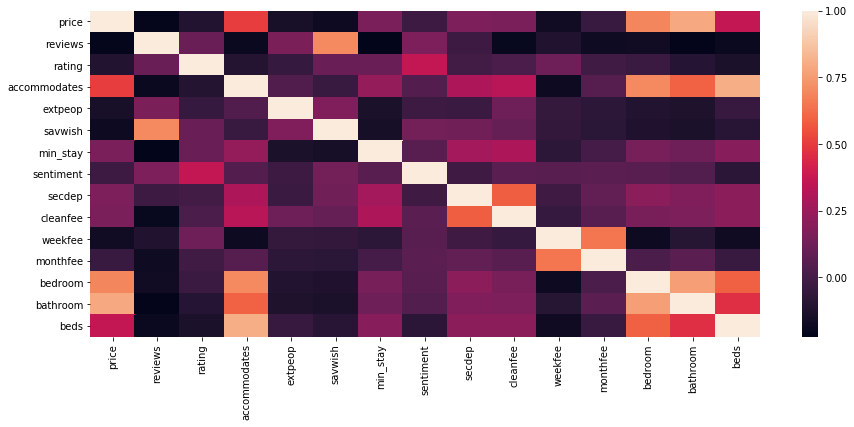

In [11]:
corr=data.iloc[:,:-1].corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

In [12]:
target=data['Revenue'].values
features=data.drop(columns='Revenue',axis=1).values

In [13]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
features=sc_X.fit_transform(features)

In [14]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=0)

In [15]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
GBTest=GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=3,max_features='sqrt',
                                min_samples_leaf=15,min_samples_split=10,loss='huber').fit(x_train,y_train)
train_test(GBTest,x_train,x_test,y_train,y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)
R2:0.8293782699760434
RMSE:9128.667835525523
TEST
R2:0.31519336764518335
RMSE:14062.74496023499


In [16]:
from sklearn.model_selection import cross_val_score
accuracy=cross_val_score(GBTest,features,target,cv=5)
print('Accuracy : %0.2f (+/-%0.2f)' % (accuracy.mean(),accuracy.std()*2))

Accuracy : 0.73 (+/-0.22)


In [17]:
from sklearn.ensemble import RandomForestRegressor
regressor=RandomForestRegressor(n_estimators=3000,random_state=0)
regressor.fit(x_train,y_train)
train_test(regressor,x_train,x_test,y_train,y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
R2:0.9754862462644925
RMSE:3895.068367989724
TEST
R2:0.4750221384538633
RMSE:15661.862104197437


In [18]:
accuracy=cross_val_score(regressor,features,target,cv=5)
print('Accuracy : %0.2f (+/-%0.2f)' % (accuracy.mean(),accuracy.std()*2))

Accuracy : 0.66 (+/-0.32)


In [38]:
features=data.drop(columns='Revenue',axis=1).values

In [39]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
labelencoder_features=LabelEncoder()
features[:,2]=labelencoder_features.fit_transform(features[:,2])
onehotencoder=OneHotEncoder(categorical_features=[2])
features=onehotencoder.fit_transform(features).toarray()

C:\Users\limo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\limo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [40]:
# # Feature scaling
# from sklearn.preprocessing import StandardScaler
# sc_X=StandardScaler()
# features=sc_X.fit_transform(features)

In [41]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=0)

In [42]:
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(X_train,y_train)
train_test(regressor,X_train,X_test,y_train,y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
R2:0.7578385718703542
RMSE:11971.415652806234
TEST
R2:0.5286749095150477
RMSE:13814.912698369155


In [43]:
import statsmodels.formula.api as sm

In [44]:
X=np.append(arr=np.ones((182,1)).astype(int),values=features,axis=1)
X_opt=X[:,:]
regressor_OLS=sm.OLS(endog=target,exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     34.19
Date:                Fri, 08 Mar 2019   Prob (F-statistic):           5.32e-46
Time:                        18:32:46   Log-Likelihood:                -1968.6
No. Observations:                 182   AIC:                             3975.
Df Residuals:                     163   BIC:                             4036.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.641e+04   4651.816     -3.528      0.001   -2.56e+04   -7227.031
x1         -8428.0125   1.11e+04     -0.756      0.451   -3.04e+04    1.36e+04
x2         -8256.1836   1.15e+04     -0.717      0.475    -3.1e+04    1.45e+04
x3          -748.2133   4194.472     -0.178      0.859   -9030.721    7534.294
x4         -2529.7221   3460.046     -0.731      0.466   -9362.013    4302.569
x5          3549.5100   3725.037      0.953      0.342   -3806.039    1.09e+04
x6            -5.6128      4.983     -1.126      0.262     -15.453       4.227
x7          -151.5950     54.047     -2.805      0.006    -258.318     -44.871
x8          3304.2553    873.407      3.783      0.000    1579.605    5028.905
x9          2589.8148   2249.541      1.151      0.251   -1852.184    7031.814
x10           81.1845      5.023     16.162      0.000      71.266      91.103
x11           23.2370    445.800      0.052      0.958    -857.052     903.526
x12         3092.2515    981.119      3.152      0.002    1154.909    5029.593
x13        -2800.7083   2571.223     -1.089      0.278   -7877.908    2276.491
x14         2248.4164   2834.011      0.793      0.429   -3347.692    7844.525
x15        -3484.0670   2857.722     -1.219      0.225   -9126.995    2158.861
x16         4790.1035   2733.802      1.752      0.082    -608.129    1.02e+04
x17         3210.5643   2072.040      1.549      0.123    -880.936    7302.065
x18          594.6161   2935.050      0.203      0.840   -5201.006    6390.238
x19        -2476.4923   1095.533     -2.261      0.025   -4639.759    -313.225
==============================================================================
Omnibus:                      116.308   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1071.377
Skew:                           2.255   Prob(JB):                    2.26e-233
Kurtosis:                      13.997   Cond. No.                     3.83e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.08e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [45]:
X=np.append(arr=np.ones((182,1)).astype(int),values=features,axis=1)
X_opt=X[:,[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19]]
regressor_OLS=sm.OLS(endog=target,exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     36.42
Date:                Fri, 08 Mar 2019   Prob (F-statistic):           8.68e-47
Time:                        18:32:46   Log-Likelihood:                -1968.6
No. Observations:                 182   AIC:                             3973.
Df Residuals:                     164   BIC:                             4031.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.636e+04   4511.501     -3.626      0.000   -2.53e+04   -7448.338
x1         -8414.6826   1.11e+04     -0.757      0.450   -3.04e+04    1.35e+04
x2         -8244.7949   1.15e+04     -0.718      0.474   -3.09e+04    1.44e+04
x3          -738.7907   4177.814     -0.177      0.860   -8988.029    7510.447
x4         -2532.6041   3449.069     -0.734      0.464   -9342.910    4277.702
x5          3574.4199   3683.005      0.971      0.333   -3697.801    1.08e+04
x6            -5.5967      4.959     -1.129      0.261     -15.387       4.194
x7          -151.7138     53.835     -2.818      0.005    -258.013     -45.415
x8          3307.0949    869.051      3.805      0.000    1591.123    5023.067
x9          2574.6535   2223.864      1.158      0.249   -1816.443    6965.750
x10           81.1588      4.984     16.285      0.000      71.318      90.999
x11         3092.9750    978.034      3.162      0.002    1161.814    5024.136
x12        -2784.6629   2544.956     -1.094      0.275   -7809.767    2240.441
x13         2269.3685   2796.817      0.811      0.418   -3253.044    7791.781
x14        -3491.0969   2845.845     -1.227      0.222   -9110.317    2128.123
x15         4789.8975   2725.474      1.757      0.081    -591.646    1.02e+04
x16         3206.9118   2064.548      1.553      0.122    -869.611    7283.434
x17          588.7239   2923.941      0.201      0.841   -5184.699    6362.147
x18        -2475.5526   1092.049     -2.267      0.025   -4631.842    -319.264
==============================================================================
Omnibus:                      116.193   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1068.453
Skew:                           2.253   Prob(JB):                    9.74e-233
Kurtosis:                      13.981   Cond. No.                     4.24e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.7e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""